In [1]:
#import libraries
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import nltk
import numpy as np
nltk.download('punkt')
nltk.download('stopwords')
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from scipy.stats import poisson, uniform
from sklearn.model_selection import RandomizedSearchCV

[nltk_data] Downloading package punkt to C:\Users\Josiah
[nltk_data]     Lee\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Josiah
[nltk_data]     Lee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.DataFrame(pd.read_csv('../Twitter Sentiment/cleanedNspelt.csv'))

def helper(string):
    temp = []
    for word in string[1:-1].split(','):
        word = word.strip()
        word = word[1:-1]
        if word:
          temp.append(word)  
    return temp
data.filtered_tokens = data.filtered_tokens.apply(helper)

Use if machine not strong

In [3]:
#data = data.iloc[25000:75000]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data.filtered_tokens, data.labels, stratify = data.labels, test_size=0.2, random_state=42)

In [5]:
vectorizer = CountVectorizer(binary=True, ngram_range=(1, 2), stop_words='english')
sentences = [' '.join(words) for words in X_train]

# Fit and transform the sentences
one_hot_encoded = vectorizer.fit_transform(sentences)

In [6]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
test = SelectKBest(score_func=chi2, k=1000)

X_train_new = test.fit_transform(one_hot_encoded, y_train)

In [7]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
distributions = {'n_estimators': poisson(50), 'max_depth': poisson(10)}
rscv = RandomizedSearchCV(rf, distributions, random_state=42, n_jobs=-1, verbose=2, n_iter = 30)
rscv.fit(X_train_new, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=30, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001C65BA4D420>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001C61B69FC10>},
                   random_state=42, verbose=2)

In [8]:
rscv.best_estimator_

RandomForestClassifier(max_depth=18, n_estimators=50)

In [9]:
sen = [' '.join(words) for words in X_test]
X_test_new = vectorizer.transform(sen)
X_test_new = test.transform(X_test_new)

In [10]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = rscv.predict(X_test_new)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# You can also print a classification report for more details
print(classification_report(y_test, y_pred))


Accuracy: 0.70
              precision    recall  f1-score   support

           0       0.77      0.57      0.66     10000
           1       0.66      0.83      0.74     10000

    accuracy                           0.70     20000
   macro avg       0.72      0.70      0.70     20000
weighted avg       0.72      0.70      0.70     20000



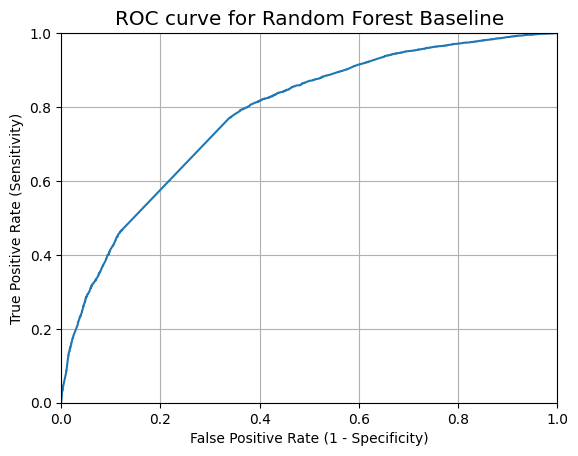

In [11]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
y_pred_prob = rscv.predict_proba(X_test_new)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Random Forest Baseline')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [12]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, y_pred_prob))

0.779262715
